### Library Import

In [142]:
import os
from typing import Any, List, Dict, Tuple
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, plot_importance
import optuna
from data_preprocessing import *
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Data Load

In [143]:
# 파일 호출
data_path: str = "/data/ephemeral/home/BTC/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [144]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:02<00:00, 36.00it/s]


### EDA (Explanatory Data Analysis)

### Feature engineering

In [145]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type" : "_type",

    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",

    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",

    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close": "close",
    
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "taker_buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "taker_sell_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "taker_buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "taker_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "taker_buy_sell_ratio",

    "hourly_network-data_addresses-count_addresses_count_active": "addresses_count_active",
    "hourly_network-data_addresses-count_addresses_count_sender": "addresses_count_sender",
    "hourly_network-data_addresses-count_addresses_count_receiver": "addresses_count_receiver",

    "hourly_network-data_block-bytes_block_bytes": "block_bytes",

    "hourly_network-data_block-count_block_count": "block_count",
    
    "hourly_network-data_block-interval_block_interval": "block_interval",

    "hourly_network-data_blockreward_blockreward": "blockreward",
    "hourly_network-data_blockreward_blockreward_usd": "blockreward_usd",
    
    "hourly_network-data_difficulty_difficulty": "difficulty",

    "hourly_network-data_fees_fees_block_mean": "fees_block_mean",
    "hourly_network-data_fees_fees_block_mean_usd": "fees_block_mean_usd",
    "hourly_network-data_fees_fees_total": "fees_total",
    "hourly_network-data_fees_fees_total_usd": "fees_total_usd",
    "hourly_network-data_fees_fees_reward_percent": "fees_reward_percent",

    "hourly_network-data_fees-transaction_fees_transaction_mean": "fees_transaction_mean",
    "hourly_network-data_fees-transaction_fees_transaction_mean_usd": "fees_transaction_mean_usd",
    "hourly_network-data_fees-transaction_fees_transaction_median": "fees_transaction_median",
    "hourly_network-data_fees-transaction_fees_transaction_median_usd": "fees_transaction_median_usd",

    "hourly_network-data_hashrate_hashrate": "hashrate",

    "hourly_network-data_supply_supply_total": "supply_total",
    "hourly_network-data_supply_supply_new": "supply_new",

    "hourly_network-data_tokens-transferred_tokens_transferred_total": "tokens_transferred_total",
    "hourly_network-data_tokens-transferred_tokens_transferred_mean": "tokens_transferred_mean",
    "hourly_network-data_tokens-transferred_tokens_transferred_median": "tokens_transferred_median",

    "hourly_network-data_transactions-count_transactions_count_total": "transactions_count_total",
    "hourly_network-data_transactions-count_transactions_count_mean": "transactions_count_mean",

    "hourly_network-data_utxo-count_utxo_count": "utxo_count",
    
    "hourly_network-data_velocity_velocity_supply_total": "velocity_supply_total"
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 43)

In [146]:
# tmp_df =  df.loc[df["_type"]=="train"].drop(columns=["_type"])
# corr = tmp_df.drop(["ID", "target"], axis=1).corr().loc["close"].sort_values(ascending = False)
# corr

In [147]:
# continuous 열을 따로 할당해둠
conti_cols: List[str] = [
    "close",
    "open_interest",
    "difficulty",
    "supply_total",
    "utxo_count"
]

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

In [148]:
df

,ID,target,_type,funding_rates,long_liquidations,short_liquidations,long_liquidations_usd,short_liquidations_usd,open_interest,close,...,utxo_count_14,utxo_count_15,utxo_count_16,utxo_count_17,utxo_count_18,utxo_count_19,utxo_count_20,utxo_count_21,utxo_count_22,utxo_count_23
0,2023-01-01 00:00:00,2.0,train,0.005049,0.012000,0.000000,197.51610,0.00000,6.271344e+09,16536.747967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01 01:00:00,1.0,train,0.005049,0.000000,0.712000,0.00000,11833.56104,6.288683e+09,16557.136536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-01 02:00:00,1.0,train,0.005049,0.000000,0.000000,0.00000,0.00000,6.286796e+09,16548.149805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-01 03:00:00,1.0,train,0.005067,0.593000,0.000000,9754.76891,0.00000,6.284575e+09,16533.632875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-01 04:00:00,2.0,train,0.006210,0.361000,0.000000,5944.43714,0.00000,6.291582e+09,16524.712159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,2024-04-26 03:00:00,NaN,test,NaN,0.710000,0.243500,45484.20433,15682.76464,1.486836e+10,NaN,...,179565695.0,179552815.0,179543052.0,179504816.0,179479822.0,179474550.0,179469208.0,179467442.0,179463219.0,179459713.0
11548,2024-04-26 04:00:00,NaN,test,NaN,6.577208,0.146000,420718.03779,9419.65430,NaN,NaN,...,179575936.0,179565695.0,179552815.0,179543052.0,179504816.0,179479822.0,179474550.0,179469208.0,179467442.0,179463219.0
11549,2024-04-26 05:00:00,NaN,test,NaN,1.797163,5.216490,114902.59095,337367.12807,NaN,NaN,...,179593285.0,179575936.0,179565695.0,179552815.0,179543052.0,179504816.0,179479822.0,179474550.0,179469208.0,179467442.0
11550,2024-04-26 06:00:00,NaN,test,NaN,0.803000,1.656000,51434.51531,106931.54104,NaN,NaN,...,179602579.0,179593285.0,179575936.0,179565695.0,179552815.0,179543052.0,179504816.0,179479822.0,179474550.0,179469208.0


In [149]:
# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

### Model Training

xgboost 라이브러리에 구현되어 있는 XGBRegressor 모델을 사용하여 학습 및 평가를 진행합니다. xgboost의 래퍼 클래스(wrapper class) 중 **사이킷런 래퍼**를 사용할 예정입니다.

#### model parameter (XGBRegressor)
* n_estimator: 트리의 개수 (디폴트 = 100)  

* learning_rate: 학습 단계별 가중치를 얼마나 사용할지(이전 결과를 얼마나 반영할 것인지) 결정. 일반적으로 0.01 ~ 0.2

* max_depth: 트리의 최대 깊이. (디폴트 = 6) 일반적으로 3 ~ 10  

* min_child_weight: child에서 필요한 모든 관측치에 대한 가중치의 최소 합. 이 값보다 샘플 수가 작으면 leaf node가 된다. 너무 큰 값을 적용하면 과소적합이 될 수 있다.  

* early stopping_rounds: 최대한 몇 개의 트리를 완성해볼 것인지 결정. valid loss에 더 이상 진전이 없으면 멈춘다. n_estimator가 높을 때 주로 사용  

* gamma: 트리에서 추가적으로 가지를 나눌지를 결정할 최소 손실 감소값. 값이 클수록 과적합 감소 효과  

* subsample: 각 트리마다 데이터 샘플링 비율. (디폴트 = 1) 일반적으로 0.5 ~ 1  

* colsample_bytree: 각 트리마다 feature 샘플링 비율. (디폴트 = 1) 일반적으로 0.5 ~ 1  

* reg_lambda: L2 regularization 가중치 (디폴트 = 1)  

* reg_alpha: L1 regularization 가중치 (디폴트 = 1)  

* scale_pos_weight: 데이터가 불균형할때 사용, 0보다 큰 값. (디폴트 = 1) 보통 값을 (음성 데이터 수)/(양성 데이터 수) 값으로 한다. 

#### fit 파라미터

* early_stopping_rounds:
* eval_metric: 
* eval_set:


In [150]:
X_train = train_df.drop(["ID", "target", "close"], axis=1)
y_train = train_df["close"]
target = train_df["target"]

In [151]:
def close_to_class(series: pd.Series) -> pd.Series:
    """close 변수를 target값으로 변환하는 함수입니다.

    Args:
        series (pd.Series): 변환을 원하는 close 변수

    Returns:
        pd.Series: 변환된 target 값
    """
    close = pd.DataFrame()
    close['close'] = series
    close['close_lag1'] = close['close'].shift(1)
    close['close_lag1_percent'] = (close['close'] - close['close_lag1']) / close['close_lag1']
    close['class'] = close['close']
    for i in range(close.shape[0]):
        if close.loc[i, 'close_lag1_percent'] < -0.005:
            close.loc[i, 'class'] = 0
        elif close.loc[i, 'close_lag1_percent'] < 0:
            close.loc[i, 'class'] = 1
        elif close.loc[i, 'close_lag1_percent'] < 0.005:
            close.loc[i, 'class'] = 2
        else:
            close.loc[i, 'class'] = 3
            
    return close["class"].shift(-1).fillna(method="ffill")

In [152]:
# 모델 평가
def evaluate(valid_target: pd.Series, 
             y_valid: pd.Series, 
             y_pred: np.ndarray, 
             metric: str
) -> float:
    """평가지표 metric을 반환하는 함수입니다.

    Args:
        valid_target: (pd.Series): k-fold로 분할한 target의 검증 데이터
        y_valid (pd.Series): k-fold로 분할한 close의 검증 데이터
        y_pred (np.ndarray): 모델을 사용하여 예측한 변수
        metric (str): 사용할 평가지표 metric 이름

    Returns:
        float: 사용할 평가지표 metric 값
    """
    if metric == "accuracy":
        y_pred_class = close_to_class(y_pred)
        return accuracy_score(valid_target, y_pred_class)
    elif metric == "mae":
        return mean_absolute_error(y_valid, y_pred)
    elif metric == "mse":
        return mean_squared_error(y_valid, y_pred)
    elif metric == "mape":
        return mean_absolute_percentage_error(y_valid, y_pred)

In [153]:
def model_train(model: Any, 
                X_train: pd.DataFrame, 
                y_train: pd.Series, 
                cv: int, 
                metric: str, 
) -> Tuple[Any, float]:
    """K-Fold로 데이터를 분할한 후 전처리를 거쳐 주어진 모델로 데이터를 학습 및 평가를 진행합니다.

    Args:
        model (Any): 사용하는 모델 객체
        X_train (pd.DataFrame): 설명변수로 이루어진 학습 데이터프레임
        y_train (pd.Seris): 예측변수로 이루어진 학습 시리즈
        cv (int): 교차검증시 분할할 폴드의 수
        metric (str): 사용할 평가지표 metric 이름

    Returns:
        Any, float: 폴드 내에서 가장 평가지표 값이 높은 모델 객체, 평가지표 metric 값
    """
    kfold = KFold(n_splits=cv)
    score_list = []
    fold_model = []
    
    # warm_start는 모델의 속성으로, 같은 모델을 반복 학습할 때 이전 학습에서 학습된 파라미터를 초기화하지 않고 이어서 학습을 진행하는 옵션
    if hasattr(model, "warm_start"):
        model.warm_start = True

    # K-Fold 교차 검증
    for train_index, valid_index in kfold.split(X_train):
        X_train_fold, y_train_fold = X_train.iloc[train_index], y_train.iloc[train_index]
        X_valid, y_valid = X_train.iloc[valid_index], y_train.iloc[valid_index]

        valid_target = target[valid_index]
        
        # 전처리
        fill_feature(X_train_fold, method="mean")
        fill_feature(X_valid, method="mean")        
        
        # 모델 학습
        model.fit(X_train_fold, y_train_fold)
        fold_model.append(model)

        y_pred = model.predict(X_valid)
        score = evaluate(valid_target, y_valid, y_pred, metric=metric)  # 평가지표 metric 반환
        score_list.append(score)
    
    return fold_model[np.argmax(score_list)], np.max(score_list)

In [154]:
def objective(trial: int) -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.3, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "booster": "gbtree",
        "device": "gpu",
        "random_state": 42
    }
    
    xgb_model = XGBRegressor(**params)
    _, acc = model_train(xgb_model, X_train, y_train, cv=5, metric="accuracy")
    return acc

In [155]:
# Optuna study 생성 및 최적화 실행
# random_state를 설정한 Sampler 사용
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters: ", study.best_params)

# 최적의 하이퍼파라미터를 사용하여 최종 모델 생성
best_params = study.best_params
best_params["device"] = "gpu"
best_params["random_state"] = 42
best_xgb_model = XGBRegressor(**best_params)

# 최종 모델 평가
fold_best_xgb_model, acc = model_train(best_xgb_model, X_train, y_train, cv=5, metric="accuracy")
print(f"XGBoost model accuracy: {acc}")

[I 2024-09-25 22:12:19,113] A new study created in memory with name: no-name-eaad6de2-27ec-4587-8354-371b3ec3912d
[I 2024-09-25 22:12:24,981] Trial 0 finished with value: 0.5776255707762558 and parameters: {'n_estimators': 144, 'learning_rate': 0.07969454818643935, 'max_depth': 8, 'min_child_weight': 3, 'colsample_bytree': 0.40921304830970556, 'subsample': 0.5779972601681014}. Best is trial 0 with value: 0.5776255707762558.
[I 2024-09-25 22:12:29,205] Trial 1 finished with value: 0.5747716894977168 and parameters: {'n_estimators': 64, 'learning_rate': 0.05399484409787434, 'max_depth': 7, 'min_child_weight': 4, 'colsample_bytree': 0.3144091460070617, 'subsample': 0.9849549260809971}. Best is trial 0 with value: 0.5776255707762558.
[I 2024-09-25 22:12:34,556] Trial 2 finished with value: 0.4337899543378995 and parameters: {'n_estimators': 258, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_child_weight': 1, 'colsample_bytree': 0.5129695700716763, 'subsample': 0.762378215816

Best Hyperparameters:  {'n_estimators': 159, 'learning_rate': 0.044545369253400344, 'max_depth': 7, 'min_child_weight': 5, 'colsample_bytree': 0.5878501242431816, 'subsample': 0.7729401646786744}
XGBoost model accuracy: 0.636986301369863


### Inference

In [156]:
# fold_best_xgb_model이 학습 데이터 전체를 학습할 수 있도록 결측치 처리
X_train = fill_feature(X_train, method="mean")
X_test = test_df.drop(["ID", "target", "close"], axis=1)
X_test = fill_feature(X_test, method="mean")

In [157]:
# 학습 데이터 전체로 fold_best_xgb_model 학습
fold_best_xgb_model.fit(X_train, y_train)

# close 예측값 생성
y_test_pred = fold_best_xgb_model.predict(X_test)


# close 예측값을 등락폭에 따라 범주화
y_test_pred_class = close_to_class(y_test_pred)

In [158]:
# pd.DataFrame(y_test_pred).to_csv("predicted_values_xgb.csv", index=False)

In [159]:
# feature 중요도 시각화 함수 정의
def plot_xgb_importance(model):
    fig, axes = plt.subplots(3, 2, figsize=(24, 12))
    axes = [ax for row_axes in axes for ax in row_axes]

    plot_importance(model, max_num_features=20, importance_type="gain", 
                    title="gain", 
                    xlabel="", 
                    grid=False,
                    ax=axes[0])
    plot_importance(model, max_num_features=20, importance_type="total_gain", 
                    title="total_gain", 
                    xlabel="", 
                    grid=False,
                    ax=axes[1])
    plot_importance(model, max_num_features=20, importance_type="cover", 
                    title="cover", 
                    xlabel="", 
                    grid=False,
                    ax=axes[2])
    plot_importance(model, max_num_features=20, importance_type="total_cover", 
                    title="total_cover", 
                    xlabel="", 
                    grid=False,
                    ax=axes[3])
    plot_importance(model, max_num_features=20, importance_type="weight", 
                    title="weight", 
                    xlabel="", 
                    grid=False,
                    ax=axes[4])
    plt.show()

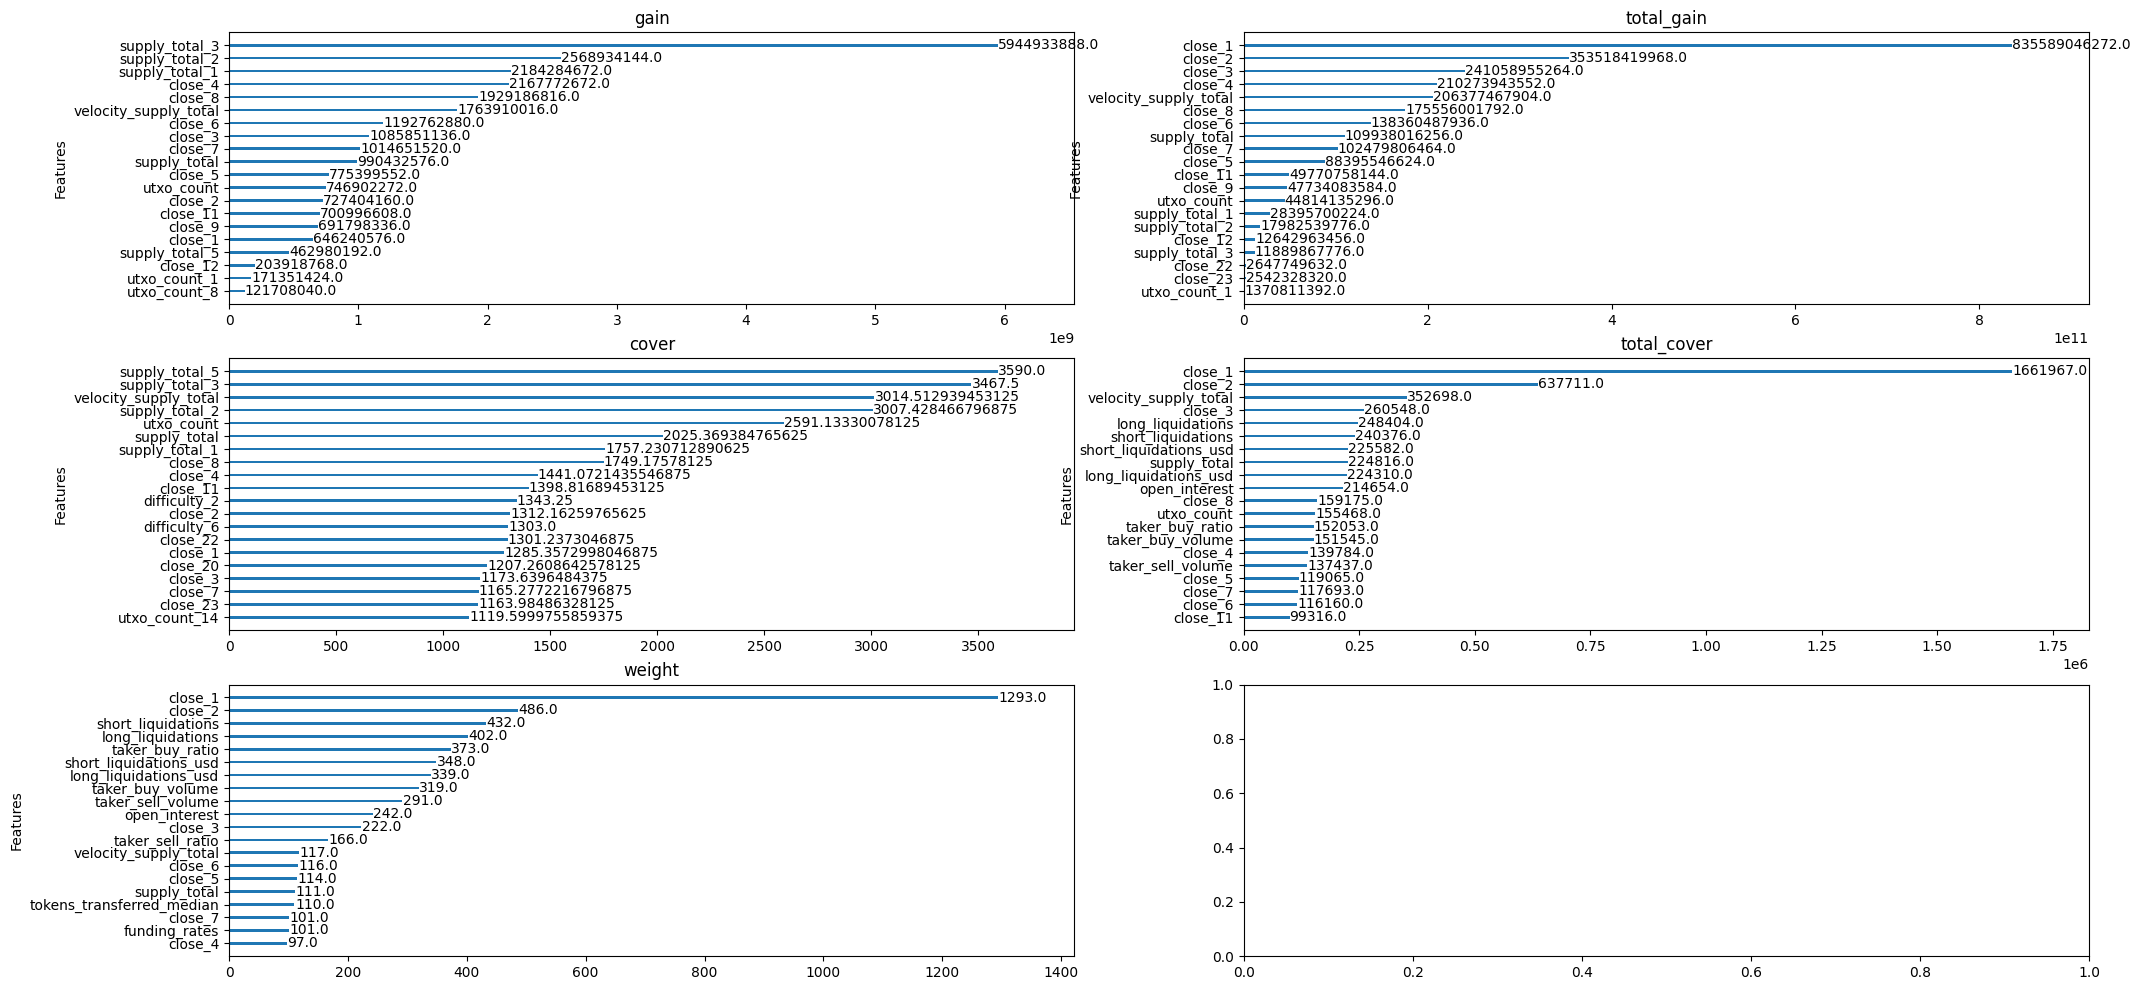

In [160]:
plot_xgb_importance(fold_best_xgb_model)

In [161]:
# 변수 중요도 출력 (importance_type: gain)
# 모델의 importance_type을 따로 지정하지 않았으면 default=gain
feature_names = train_df.drop(["ID", "target", "close"], axis=1).columns
importances = pd.Series(fold_best_xgb_model.feature_importances_, index=feature_names).sort_values(ascending=False)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
     print(importances)

# 아래 코드 수정 필요 (ylabel이 고정되어있다.)
# plt.barh(feature_names, importances)
# for idx, val in zip(range(0,len(feature_names)), importances):
#     plt.text(x=val, y=idx, s=importances[idx])
# plt.show()

supply_total_3                 0.225475
supply_total_2                 0.097433
supply_total_1                 0.082844
close_4                        0.082218
close_8                        0.073169
velocity_supply_total          0.066900
close_6                        0.045238
close_3                        0.041183
close_7                        0.038483
supply_total                   0.037564
close_5                        0.029409
utxo_count                     0.028328
close_2                        0.027588
close_11                       0.026587
close_9                        0.026238
close_1                        0.024510
supply_total_5                 0.017560
close_12                       0.007734
utxo_count_1                   0.006499
utxo_count_8                   0.004616
supply_total_4                 0.002074
close_22                       0.001702
utxo_count_23                  0.001669
close_23                       0.001461
utxo_count_4                   0.000409


### Output File Save

In [162]:
# output file 할당후 save 
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df["target"] = submission_df["target"].astype(np.int8)
submission_df.to_csv("output.csv", index=False)

### Check the Output Distribution

In [163]:
out = pd.read_csv("output.csv")
out["target"].unique()

array([2, 1, 3, 0])

In [164]:
print(out["target"].value_counts(), '\n')
print(out["target"].value_counts() / len(out["target"]))

target
2    1114
1    1089
3     295
0     294
Name: count, dtype: int64 

target
2    0.398997
1    0.390043
3    0.105659
0    0.105301
Name: count, dtype: float64
